In [2]:

""" standard imports """
import sys
import os
import numpy as np
import logging
from numpy                       import pi, cos, sin, sqrt, abs, exp, array, ndarray
from matplotlib.path             import Path
import matplotlib.pyplot         as plt
import matplotlib                as mpl
import matplotlib.colors         as colors
from mpl_toolkits.axes_grid1     import make_axes_locatable
import pickle
from itertools                   import combinations
from scipy.optimize              import minimize_scalar
from shapely.geometry            import Point, LineString, MultiPolygon, Polygon
from shapely.geometry.collection import GeometryCollection
from shapely.ops                 import cascaded_union
from shapely                     import affinity
from scipy.ndimage.filters import gaussian_filter

""" package imports """
from SuPyMode.Tools.Directories       import RootPath
from SuPyMode.Tools.Special           import Intersection
from SuPyMode.Tools.utils             import *

Mlogger = logging.getLogger(__name__)




/var/folders/z9/7t92p3213fb2p8qsqv_4lnx00000gn/T/ipykernel_26631/3469700703.py:19: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [24]:
class Circle(object):
    def __init__(self, Position, Radi, Index=None, debug='INFO', Gradient=None):


        assert not all([Index, Gradient]), "Error, you must either define an Index or a Gradient but not both."
        assert any([Index, Gradient]), "Error, you must at least define an Index or a Gradient."
        Mlogger.setLevel(getattr(logging, debug))

        self.Points   = Position
        self.Radi     = Radi
        self.Index    = Index
        self.hole     = None
        self.Gradient = Gradient
        self.Init()

    def Init(self):
        self.Object = MakeCircles([self.Points], [self.Radi])[0]
        self.C      = [Point(0,0)]


    def Plot(self):
        PlotObject(Full = [self.Object] + self.C)
    





class BaseFused():
    def __init__(self, Radius, Fusion, Angle, Theta, Index, debug, Gradient=None):

        assert not all([Index, Gradient]), "Error, you must either define an Index or a Gradient but not both."
        assert any([Index, Gradient]), "Error, you must at least define an Index or a Gradient."
        Mlogger.setLevel(getattr(logging, debug))

        self.Index   = Index
        self.Radius  = Radius
        self.Fusion  = Fusion
        self.Angle   = Angle
        self.hole    = None
        self.N       = len(self.Angle)
        self.Theta   = Deg2Rad(Theta)
        self.Gradient = Gradient
        self.GetFibers()
        self.GetTopology()

        
    def SaveToFile(self, FileName):
        FileName = os.path.join(RootPath, FileName)
        with open(FileName, "wb") as poly_file:
            pickle.dump((self.C, self.Object), poly_file, pickle.HIGHEST_PROTOCOL)
            

    def OptimizeGeometry(self):
        res = minimize_scalar(self.ComputeCost, bounds=self.Bound, method='bounded')
        Mlogger.info(f'Result Rv = {res.x}')
        return self.BuildCoupler(Rv=res.x)


    def GetHole(self):
        CenterPart = Polygon(self.C)

        Coupler  = ObjectUnion(self.Fibers)

        return CenterPart.difference(Coupler)


    def GetFibers(self):
        self.GetDistance()

        self.GetCenters()

        self.Fibers = []

        for i in range(self.N):
            self.Fibers.append( self.C[i].buffer(self.Radius) )

    def Plot(self):
        PlotObject(Full = [self.Object] + self.C)


    def ComputeDifference(self, Added, Removed):
        return abs(Added.area - Removed.Area)


    def GetDistance(self):
        alpha    = (2 - self.N) * pi / ( 2 * self.N)

        self.d = ( 1 + cos(alpha) ) - sqrt(self.N) * cos(alpha)

        self.d =  ( self.Radius - ( self.d * self.Radius ) * self.Fusion)

        self.d *= 1 / ( cos(alpha) )


    def GetMask(self, Circles):
        bound = GetBoundaries(ObjectUnion(Circles))
        n0 = NearestPoints(self.Fibers[2], Circles[0])[0]
        n1 = NearestPoints(self.Fibers[3], Circles[0])[0]

        factor = 4
        P0 = Point(factor*n0.x, factor*n0.y)
        P1 = Point(factor*n1.x, factor*n1.y)
        P2 = Point(0,0)

        mask0  = Polygon([P0, P1, P2])

        mask   = [ Rotate(Object=mask0, Angle=angle) for angle in self.Angle ]

        mask   = ObjectUnion(mask)

        return mask


    def BuildCoupler(self, Rv):
        Circles, Triangles = self.MakeVirtual(Rv=Rv)

        Added = self.GetAdded(Circles, Triangles)

        Removed = self.GetRemoved()

        Coupler = ObjectUnion(self.Fibers + [Added])
        if isinstance(Coupler, GeometryCollection):
            Coupler = MultiPolygon([P for P in Coupler if not isinstance(P, Point)])

        eps = 0.2
        Coupler = Coupler.buffer(eps).buffer(-eps)

        return Coupler


    def ComputeCost(self, Rv):
        Circles, Triangles = self.MakeVirtual(Rv=Rv)

        Added = self.GetAdded(Circles, Triangles)

        Removed = self.GetRemoved()

        Cost = self.ComputeDifference(Added, Removed)

        Mlogger.info(f'Topology: {self.Topology} \t Rv: {Rv:.0f} \t Cost: {Cost}')

        return Cost


    def GetCenters(self):
        P0 = Point(0, self.d)
        Points = Rotate(Object=P0, Angle=self.Angle)
        self.C = [ *Points ]


    def GetAdded(self, Circles, Triangles):
        if self.Topology == 'convex':
            All          = ObjectUnion(Circles+self.Fibers)

            AllTriangles = ObjectUnion(Triangles)

            Added        = AllTriangles.difference(All)

        if self.Topology == 'concave':
            f      = ObjectUnion(self.Fibers)

            b      = ObjectIntersection(Circles)

            edge   = b.difference(f)

            hole   = self.GetHole()

            mask   = self.GetMask(Circles)

            Added  = mask.intersection(edge).difference(hole)

        return Added


    def GetRemoved(self):
        combination = combinations(range(self.N), 2)
        Removed     = []
        for i,j in combination:
            Removed.append( self.Fibers[i].intersection( self.Fibers[j] ) )

        CenterPart = Removed[0]
        for geo in Removed:
            CenterPart = CenterPart.intersection(geo)

        Removed.append(CenterPart)

        area = Removed[0].area * self.N - Removed[-1].area

        Removed = ObjectUnion(Removed)

        Removed.Area = area

        return Removed

    def MakeVirtual(self, Rv):
        Triangles, Points = self.MakeTriangles(Rv=Rv)

        Circles = []
        for point in Points:
            Circles.append(Point(point).buffer(Rv))
            Circles[-1].center = point

        return Circles, Triangles



class Fused3(BaseFused):
    def __init__(self, Radius, Fusion, Index, debug='INFO', Gradient=None):
        super().__init__(Radius  = Radius,
                         Fusion  = Fusion,
                         Angle   = [0, 120, 240],
                         Theta   = 30,
                         Index   = Index,
                         debug   = debug )

        if self.Topology == 'concave':
            self.Bound = (Radius*1.5, 4000)

        else:
            self.Bound = (0, 4000)

        self.Object = self.OptimizeGeometry()
        self.Gradient = Gradient



    def GetTopology(self):
        hole     = self.GetHole()

        Coupler  = ObjectUnion(self.Fibers)

        Convex   = Coupler.convex_hull.difference(hole)

        MaxAdded = Convex.difference(Coupler)

        Removed  = self.GetRemoved()

        if MaxAdded.area > Removed.Area: self.Topology = 'convex'
        else:                            self.Topology = 'concave'


    def GetMask(self, Circles):
        bound = GetBoundaries(ObjectUnion(Circles))
        n0 = NearestPoints(self.Fibers[0], Circles[0])[0]
        n1 = NearestPoints(self.Fibers[1], Circles[0])[0]

        P0 = Point(2*n0.x, 2*n0.y)
        P1 = Point(2*n1.x, 2*n1.y)
        P2 = Point(0,0)

        mask0  = Polygon([P0, P1, P2])

        mask   = [Rotate(Object=mask0, Angle=angle) for angle in self.Angle]

        mask   = ObjectUnion(mask)

        return mask


    def MakeTriangles(self, Rv):
        self.GetCenters()

        s = self.d * cos(self.Theta)

        if self.Topology == 'concave':
            H  = -sqrt( (Rv - self.Radius)**2 - s**2 )
            sign = 1

        if self.Topology == 'convex':
            H  = -sqrt( (self.Radius + Rv)**2 - s**2 )
            sign = -1

        R  = sign * self.d * sin(self.Theta) + H

        Points    = Rotate( Object=Point(0, R), Angle=240 )

        Points    = [ *Rotate( Object=Points, Angle  = self.Angle ) ]

        Triangle  = Polygon( [ self.C[0], self.C[1], Points[0] ] )

        Triangles = [ *Rotate( Object=Triangle, Angle=self.Angle ) ]

        Triangles = ObjectUnion(Triangles)

        if self.Topology == 'concave':
            Triangles = Rotate( Object=Triangles, Angle=[180] )
            Points    = [ Rotate( Object=pts, Angle=[180] ) for pts in Points]

        return Triangles, Points
    
    

class Fused2(BaseFused):
    def __init__(self, Radius, Fusion, Index, debug='INFO', Gradient=None):
        super().__init__(Radius  = Radius,
                         Fusion  = Fusion,
                         Angle   = [0, 180],
                         Theta   = 90,
                         Index   = Index,
                         debug   = debug)

        if self.Topology == 'concave':
            self.Bound = (Radius*1.5, 4000)

        else:
            self.Bound = (0, 4000)

        self.Object = self.OptimizeGeometry()
        self.Gradient = Gradient


    def GetTopology(self):
        Coupler  = ObjectUnion(self.Fibers)

        Convex   = Coupler.convex_hull

        MaxAdded = Convex.difference(Coupler)

        Removed  = self.GetRemoved()

        if MaxAdded.area > Removed.Area: self.Topology = 'convex'
        else:                            self.Topology = 'concave'


    def GetMask(self, Circles):
        bound = GetBoundaries(ObjectUnion(Circles))
        n0 = NearestPoints(self.Fibers[0], Circles[0])[0]
        n1 = NearestPoints(self.Fibers[1], Circles[0])[0]

        factor = 4
        P0 = Point(factor*n0.x, factor*n0.y)
        P1 = Point(factor*n1.x, factor*n1.y)
        P2 = Point(0,0)

        mask0  = Polygon([P0, P1, P2])

        mask   = [ Rotate(Object=mask0, Angle=angle) for angle in self.Angle ]

        mask   = ObjectUnion(mask)

        return mask

    def GetAdded(self, Circles, Triangles):
        if self.Topology == 'convex':
            All          = ObjectUnion(Circles+self.Fibers)

            AllTriangles = ObjectUnion(Triangles)

            Added        = AllTriangles.difference(All)

        if self.Topology == 'concave':
            f      = ObjectUnion(self.Fibers)

            b      = ObjectIntersection(Circles)

            edge   = b.difference(f)

            mask   = self.GetMask(Circles)

            Added  = mask.intersection(edge)


        return Added


    def MakeTriangles(self, Rv):
        self.GetCenters()

        if self.Topology == 'concave':
            H  = -sqrt( (Rv - self.Radius)**2 - self.d**2 )

        if self.Topology == 'convex':
            H  = -sqrt( (self.Radius + Rv)**2 - self.d**2 )

        R  =  abs(H)

        Points    = Rotate( Object=Point(0, R), Angle=90 )

        Points    = [ *Rotate( Object=Points, Angle  = self.Angle ) ]

        Triangle  = Polygon( [ self.C[0], self.C[1], Points[0] ] )

        Triangles = [ *Rotate( Object=Triangle, Angle=self.Angle ) ]

        Triangles = ObjectUnion(Triangles)


        if self.Topology == 'concave':
            Triangles = Rotate( Object=Triangles, Angle=[180] )
            Points    = [ Rotate( Object=pts, Angle=[180] ) for pts in Points]

        return Triangles, Points

    


class Fused4(BaseFused):
    def __init__(self, Radius, Fusion, Index, debug='INFO', Gradient=None):
        super().__init__(Radius  = Radius,
                         Fusion  = Fusion,
                         Angle   = [0, 90, 180, 270],
                         Theta   = 45,
                         Index   = Index,
                         debug   = debug)


        if self.Topology == 'concave':
            self.Bound = (Radius*1.5, 4000)

        else:
            self.Bound = (0, 4000)

        self.Object = self.OptimizeGeometry()
        self.Gradient = Gradient


    def GetTopology(self):
        CenterTriangle = Polygon(self.C)

        Coupler  = ObjectUnion(self.Fibers)

        hole     = CenterTriangle.difference(Coupler)

        self.hole = hole

        Convex   = Coupler.convex_hull.difference(hole)

        MaxAdded = Convex.difference(Coupler)

        Removed  = self.GetRemoved()

        if MaxAdded.area > Removed.Area: self.Topology = 'convex'
        else:                            self.Topology = 'concave'


    def GetAdded(self, Circles, Triangles):
        if self.Topology == 'convex':
            All          = ObjectUnion(Circles+self.Fibers)

            AllTriangles = ObjectUnion(Triangles)

            Added        = AllTriangles.difference(All)

        if self.Topology == 'concave':
            f      = ObjectUnion(self.Fibers)

            b      = ObjectIntersection(Circles)

            edge   = b.difference(f)

            hole   = self.GetHole()

            mask   = self.GetMask(Circles)

            Added  = mask.intersection(edge).difference(hole)

        return Added


    def MakeTriangles(self, Rv):
        self.GetCenters()

        s = self.d * cos(self.Theta)

        if self.Topology == 'concave':
            H  = -sqrt( (Rv - self.Radius)**2 - s**2 )
            sign = 1

        if self.Topology == 'convex':
            H  = -sqrt( (self.Radius + Rv)**2 - s**2 )
            sign = -1

        R  = sign * self.d * sin(self.Theta) + H

        Points    = Rotate( Object=Point(0, R), Angle=self.Theta * 180/pi )

        Points    = [ *Rotate( Object=Points, Angle  = self.Angle ) ]

        Triangle  = Polygon( [ self.C[0], self.C[1], Points[2] ] )

        Triangles = [ *Rotate( Object=Triangle, Angle=self.Angle ) ]

        Triangles = ObjectUnion( Triangles )

        if self.Topology == 'concave':
            Triangles = Rotate( Object=Triangles, Angle=[180] )
            Points    = [ Rotate( Object=pts, Angle=[180] ) for pts in Points]

        return Triangles, Points


/var/folders/z9/7t92p3213fb2p8qsqv_4lnx00000gn/T/ipykernel_26631/829699250.py:192: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  Removed.Area = area
/var/folders/z9/7t92p3213fb2p8qsqv_4lnx00000gn/T/ipykernel_26631/829699250.py:202: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  Circles[-1].center = point


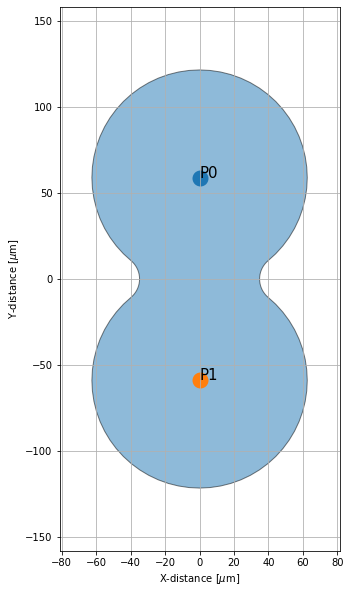

Struc=2-Fusion=0.1


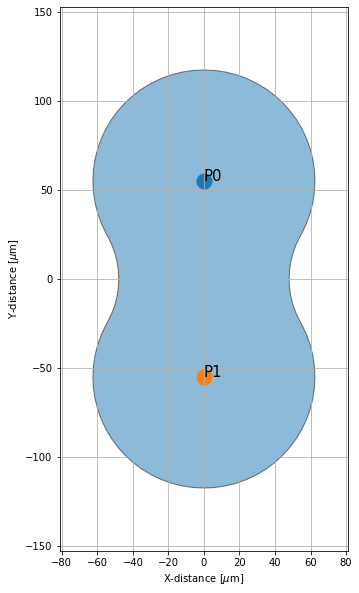

Struc=2-Fusion=0.2


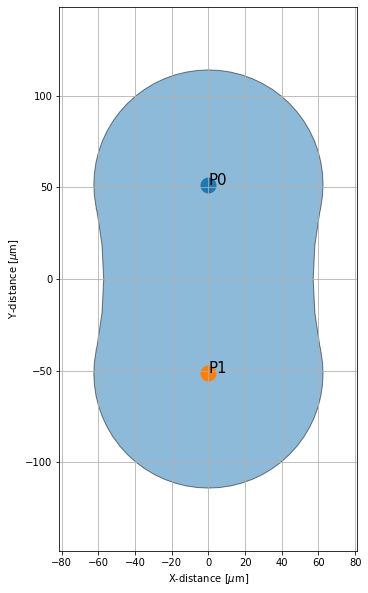

Struc=2-Fusion=0.3


/var/folders/z9/7t92p3213fb2p8qsqv_4lnx00000gn/T/ipykernel_26631/829699250.py:124: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  Coupler = MultiPolygon([P for P in Coupler if not isinstance(P, Point)])


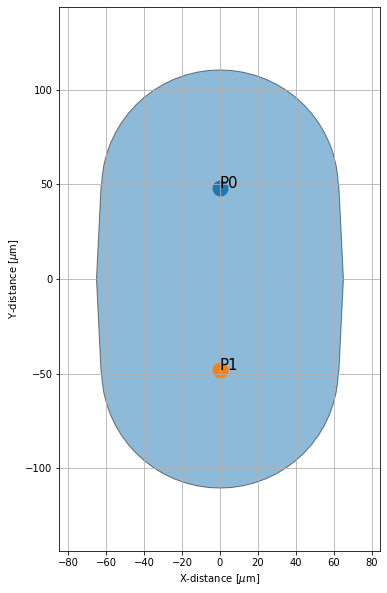

Struc=2-Fusion=0.4


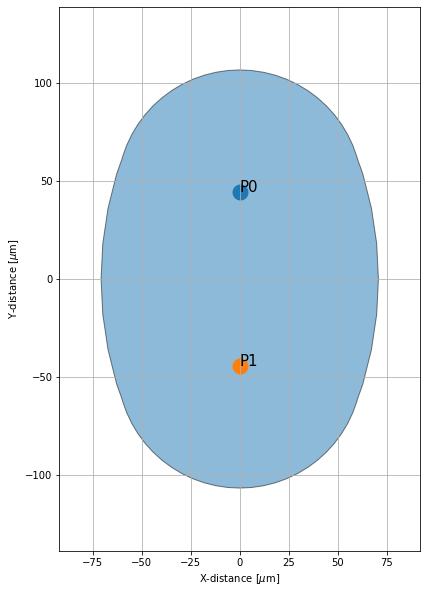

Struc=2-Fusion=0.5


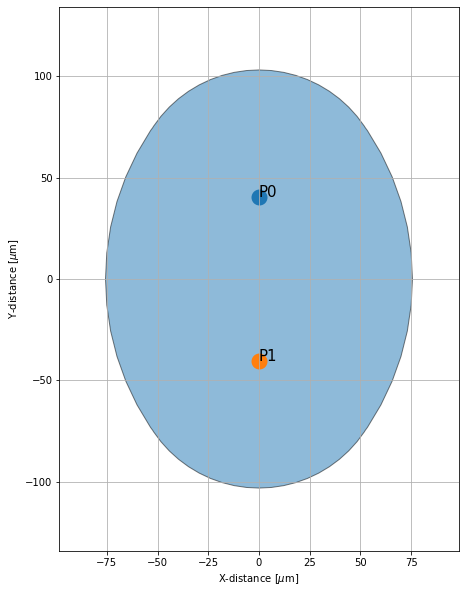

Struc=2-Fusion=0.6


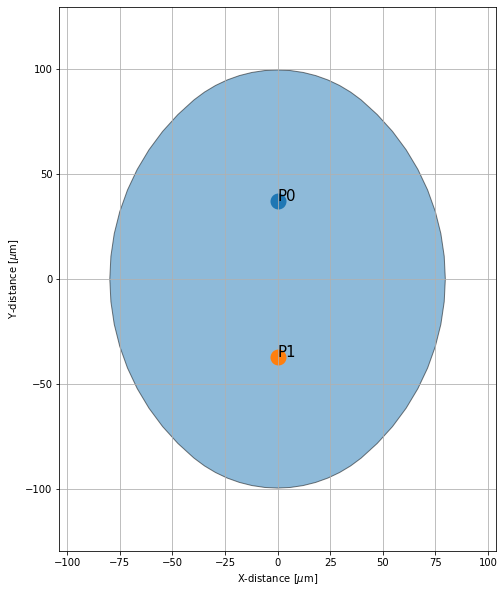

Struc=2-Fusion=0.7


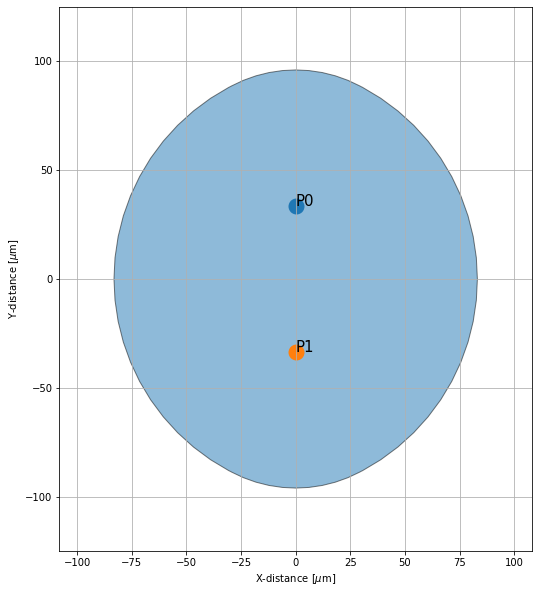

Struc=2-Fusion=0.8


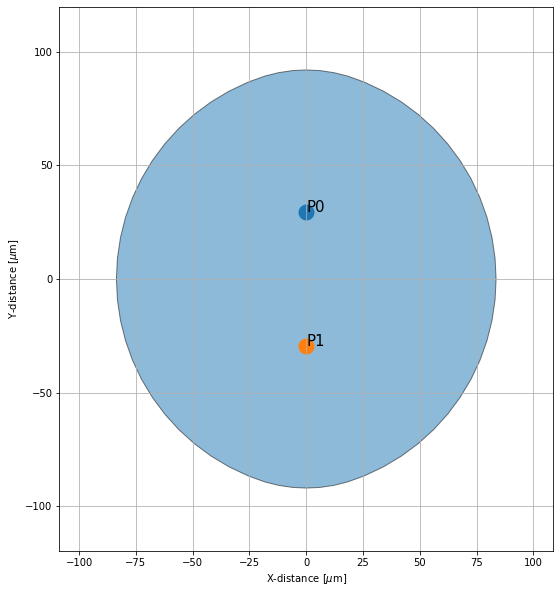

Struc=2-Fusion=0.9


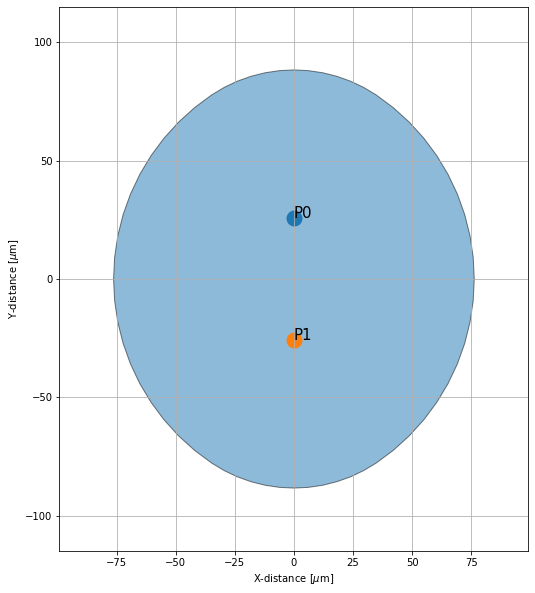

Struc=2-Fusion=1.0


In [27]:

for Fusion in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    a = Fused2(Radius=62.5, Fusion=Fusion, Index=1)
    a.Plot()
    Name = f"Struc=2-Fusion={Fusion:.1f}"
    a.SaveToFile(Name)
    print(Name)